In [6]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

In [7]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [8]:
import numpy as np
import pandas as pd
import warnings

# Configuração inicial
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by=['Ticker', 'Date'], inplace=True)

# Cálculo da mudança no preço
price_data['change_in_price'] = price_data['Close'].diff()
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)
price_data['change_in_price'] = np.where(mask, np.nan, price_data['change_in_price'])
price_data[price_data.isna().any(axis = 1)]


# Função de suavização exponencial
def exponential_smoothing(data, alpha):
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    return np.sign(data.shift(-d) - data)

# Função para calcular o target e ajustar valores zero para -1
def calculate_target_verify(data, d):
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1
    return target

# Função OBV ajustada
def obv(group, smoothed_col):
    Volume = group['Volume']
    change = group[smoothed_col].diff()
    prev_obv = 0
    obv_values = []
    for i, j in zip(change, Volume):
        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv
        prev_obv = current_obv
        obv_values.append(current_obv)
    return pd.Series(obv_values, index=group.index)

# Lista de alphas e parâmetros gerais
alpha_list = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90]
n = 14
d = 45
t = 14
e = 14

# Loop para cálculos por alpha
for alpha in alpha_list:
    smoothed_col = f'Smoothed_Close_{alpha:.2f}'
    target_col = f'Prediction_{alpha:.2f}'
    obv_col = f'OBV_{alpha:.2f}'
    price_rate_col = f'Price_Rate_Of_Change_{alpha:.2f}'
    macd_col = f'MACD_{alpha:.2f}'
    macd_ema_col = f'MACD_EMA_{alpha:.2f}'
    low_col = f'low_{t}_{alpha:.2f}'
    high_col = f'high_{t}_{alpha:.2f}'
    k_percent_col = f'k_percent_{alpha:.2f}'
    r_percent_col = f'r_percent_{alpha:.2f}'
    
    # Suavização exponencial
    price_data[smoothed_col] = price_data.groupby('Ticker')['Close'].transform(
        lambda x: exponential_smoothing(x.values, alpha)
    )
    
    # Target
    price_data[target_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: calculate_target(x, d)
    )
    
    # OBV
    obv_groups = price_data.groupby('Ticker').apply(lambda group: obv(group, smoothed_col))
    price_data[obv_col] = obv_groups.reset_index(level=0, drop=True)
    
    # Price Rate of Change
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(
        lambda x: x.pct_change(periods=e)
    )
    
    
    # %R
    low_t = price_data[['Ticker', 'Low']].copy()
    high_t = price_data[['Ticker', 'High']].copy()
    low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window=t).min())
    high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window=t).max())
    r_percent = ((high_t - price_data[smoothed_col]) / (high_t - low_t)) * (-100)
    price_data[low_col] = low_t
    price_data[high_col] = high_t
    price_data[r_percent_col] = r_percent

    # %K    
    k_percent = ((price_data[smoothed_col] - low_t) / (high_t - low_t)) * 100
    price_data[k_percent_col] = k_percent
    
    # MACD
    ema_26 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=26).mean())
    ema_12 = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.ewm(span=12).mean())
    macd = ema_12 - ema_26
    ema_9_macd = macd.ewm(span=9).mean()
    price_data[macd_col] = macd
    price_data[macd_ema_col] = ema_9_macd

    # Calculando o Price Rate of Change (ROC) usando a coluna suavizada correspondente
    price_data[price_rate_col] = price_data.groupby('Ticker')[smoothed_col].transform(lambda x: x.pct_change(periods=e))


# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)


price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-d)

# Drop linhas com valores ausentes
price_data = price_data.dropna()
# Desativa warnings
warnings.filterwarnings("ignore")
# Visualização final
price_data.tail()




,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_14_0.10,high_14_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_14_0.20,high_14_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_14_0.30,high_14_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_14_0.40,high_14_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_14_0.50,high_14_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,Smoothed_Close_0.60,Prediction_0.60,OBV_0.60,Price_Rate_Of_Change_0.60,low_14_0.60,high_14_0.60,r_percent_0.60,k_percent_0.60,MACD_0.60,MACD_EMA_0.60,Smoothed_Close_0.70,Prediction_0.70,OBV_0.70,Price_Rate_Of_Change_0.70,low_14_0.70,high_14_0.70,r_percent_0.70,k_percent_0.70,MACD_0.70,MACD_EMA_0.70,Smoothed_Close_0.80,Prediction_0.80,OBV_0.80,Price_Rate_Of_Change_0.80,low_14_0.80,high_14_0.80,r_percent_0.80,k_percent_0.80,MACD_0.80,MACD_EMA_0.80,Smoothed_Close_0.90,Prediction_0.90,OBV_0.90,Price_Rate_Of_Change_0.90,low_14_0.90,high_14_0.90,r_percent_0.90,k_percent_0.90,MACD_0.90,MACD_EMA_0.90,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
11734,2024-11-11,59.750000,59.869999,58.650002,58.650002,58.131153,24483700,VALE3.SA,-1.980000,61.409520,-1.0,3068743348,0.004919,58.650002,63.990002,-48.323623,51.676377,0.382188,0.433060,61.254148,-1.0,2569015870,0.003339,58.650002,63.990002,-51.233205,48.766795,0.318598,0.382283,60.918491,-1.0,589639662,0.001941,58.650002,63.990002,-57.518928,42.481072,0.285651,0.364724,60.537116,-1.0,995282066,-0.001557,58.650002,63.990002,-64.660773,35.339227,0.251562,0.358819,60.157332,-1.0,869832626,-0.006057,58.650002,63.990002,-71.772835,28.227165,0.214747,0.353215,59.795081,-1.0,480394938,-0.010965,58.650002,63.990002,-78.556568,21.443432,0.177898,0.346738,59.456497,-1.0,598030442,-0.015979,58.650002,63.990002,-84.897095,15.102905,0.142259,0.339758,59.147338,-1.0,-973152942,-0.020848,58.650002,63.990002,-90.686583,9.313417,0.108310,0.332617,58.875236,-1.0,-807441638,-0.025318,58.650002,63.990002,-95.782120,4.217880,0.076390,0.325518,1.980000,0.000000,32.451210,58.650002,-1.0,54.020000
11735,2024-11-12,58.580002,58.590000,57.200001,57.320000,56.812916,26967600,VALE3.SA,-1.330002,61.000568,-1.0,3041775748,0.001109,57.200001,63.990002,-44.026998,55.973002,0.316024,0.409653,60.467319,-1.0,2542048270,-0.004002,57.200001,63.990002,-51.880449,48.119551,0.198989,0.345624,59.838944,-1.0,562672062,-0.008720,57.200001,63.990002,-61.134869,38.865131,0.116122,0.315003,59.250270,-1.0,968314466,-0.014449,57.200001,63.990002,-69.804586,30.195414,0.039158,0.294887,58.738666,-1.0,842865026,-0.019993,57.200001,63.990002,-77.339249,22.660751,-0.032350,0.276102,58.310032,-1.0,453427338,-0.024805,57.200001,63.990002,-83.651970,16.348030,-0.096509,0.258088,57.960949,-1.0,571062842,-0.028668,57.200001,63.990002,-88.793109,11.206891,-0.152935,0.241220,57.685467,-1.0,-1000120542,-0.031495,57.200001,63.990002,-92.850272,7.149728,-0.201895,0.225714,57.475523,-1.0,-834409238,-0.033301,57.200001,63.990002,-95.942230,4.057770,-0.243863,0.211642,1.330002,0.000000,27.744854,57.320000,-1.0,52.660000
11736,2024-11-13,57.320000,57.720001,57.110001,57.160000,56.654331,20354900,VALE3.SA,-0.160000,60.616511,-1.0,3021420848,-0.003177,57.110001,63.990002,-49.033283,50.966717,0.229949,0.373712,59.805855,-1.0,2521693370,-0.011608,57.110001,63.990002,-60.816077,39.183923,0.050244,0.286548,59.035260,-1.0,542317162,-0.018789,57.110001,63.990002,-72.016577,27.983423,-0.082135,0.235575,58.414162,-1.0,947959566,-0.025641,57.110001,63.990002,-81.044173,18.955827,-0.194399,0.197030,57.949333,-1.0,822510126,-0.031247,57.110001,63.990002,-87.8

#### Se quiser rodar para um Ticker.

In [9]:
price_data = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_14_0.10,high_14_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_14_0.20,high_14_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_14_0.30,high_14_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_14_0.40,high_14_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_14_0.50,high_14_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,Smoothed_Close_0.60,Prediction_0.60,OBV_0.60,Price_Rate_Of_Change_0.60,low_14_0.60,high_14_0.60,r_percent_0.60,k_percent_0.60,MACD_0.60,MACD_EMA_0.60,Smoothed_Close_0.70,Prediction_0.70,OBV_0.70,Price_Rate_Of_Change_0.70,low_14_0.70,high_14_0.70,r_percent_0.70,k_percent_0.70,MACD_0.70,MACD_EMA_0.70,Smoothed_Close_0.80,Prediction_0.80,OBV_0.80,Price_Rate_Of_Change_0.80,low_14_0.80,high_14_0.80,r_percent_0.80,k_percent_0.80,MACD_0.80,MACD_EMA_0.80,Smoothed_Close_0.90,Prediction_0.90,OBV_0.90,Price_Rate_Of_Change_0.90,low_14_0.90,high_14_0.90,r_percent_0.90,k_percent_0.90,MACD_0.90,MACD_EMA_0.90,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10
5701,2024-11-11,12.31,12.55,12.26,12.51,12.270372,20684800,ABEV3.SA,0.180000,12.719343,-1.0,-2687255893,-0.023576,12.26,13.09,-44.657535,55.342465,-0.027866,0.015023,12.586564,-1.0,-2321489347,-0.032029,12.26,13.09,-60.654912,39.345088,-0.081478,-0.033515,12.524940,-1.0,-2594537873,-0.033182,12.26,13.09,-68.079500,31.920500,-0.101903,-0.052882,12.494360,-1.0,-1849308923,-0.032976,12.26,13.09,-71.763923,28.236077,-0.112348,-0.062955,12.479554,-1.0,-1674738905,-0.032586,12.26,13.09,-73.547741,26.452259,-0.118587,-0.069108,12.474328,-1.0,-1286346787,-0.032123,12.26,13.09,-74.177330,25.822670,-0.122597,-0.073254,12.475830,-1.0,-1476572775,-0.031542,12.26,13.09,-73.996371,26.003629,-0.125246,-0.076225,12.482679,-1.0,-1386503435,-0.030798,12.26,13.09,-73.171267,26.828733,-0.126973,-0.078445,12.494168,-1.0,-1321552573,-0.029865,12.26,13.09,-71.787015,28.212985,-0.128015,-0.080148,0.000000,0.18,40.246796,12.51,-1.0,11.25
5702,2024-11-12,12.43,12.64,12.30,12.58,12.339031,26899600,ABEV3.SA,0.070000,12.705408,-1.0,-2714155493,-0.023173,12.26,13.09,-46.336363,53.663637,-0.037421,0.004534,12.585252,-1.0,-2348388947,-0.029547,12.26,13.09,-60.813093,39.186907,-0.089866,-0.044785,12.541458,-1.0,-2567638273,-0.029101,12.26,13.09,-66.089395,33.910605,-0.108358,-0.063977,12.528616,-1.0,-1822409323,-0.027602,12.26,13.09,-67.636680,32.363320,-0.116776,-0.073720,12.529777,-1.0,-1647839305,-0.026053,12.26,13.09,-67.496779,32.503221,-0.121003,-0.079487,12.537731,-1.0,-1259447187,-0.024554,12.26,13.09,-66.538422,33.461578,-0.123090,-0.083221,12.548749,-1.0,-1449673175,-0.023113,12.26,13.09,-65.210983,34.789017,-0.123967,-0.085774,12.560536,-1.0,-1359603835,-0.021755,12.26,13.09,-63.790906,36.209094,-0.124130,-0.087582,12.571417,-1.0,-1294652973,-0.020527,12.26,13.09,-62.479936,37.520064,-0.123879,-0.088894,0.000000,0.07,45.118006,12.58,-1.0,11.02
5703,2024-11-13,12.52,12.77,12.46,12.73,12.486157,30341700,ABEV3.SA,0.150000,12.707867,-1.0,-2683813793,-0.021578,12.26,13.09,-46.040084,53.959916,-0.044285,-0.005229,12.614201,-1.0,-2318047247,-0.025083,12.26,13.09,-57.325189,42.674811,-0.093104,-0.054449,12.598021,-1.0,-2537296573,-0.022512,12.26,13.09,-59.274648,40.725352,-0.107668,-0.072715,12.609169,-1.0,-1792067623,-0.019394,12.26,13.09,-57.931437,42.068563,-0.112489,-0.081474,12.629888,-1.0,-1617497605,-0.016553,12.26,13.09,-55.435175,44.564825,-0.113531,-0.086296,12.653092,-1.0,-1229105487,-0.014045,12.26,13.09,-52.639512,47.360488,-0.112871,-0.089151,12.675624,-1.0,-1419331475,-0.011855,12.26,13.09,-49.92479

In [5]:
price_data = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close_0.10,Prediction_0.10,OBV_0.10,Price_Rate_Of_Change_0.10,low_14_0.10,high_14_0.10,r_percent_0.10,k_percent_0.10,MACD_0.10,MACD_EMA_0.10,Smoothed_Close_0.20,Prediction_0.20,OBV_0.20,Price_Rate_Of_Change_0.20,low_14_0.20,high_14_0.20,r_percent_0.20,k_percent_0.20,MACD_0.20,MACD_EMA_0.20,Smoothed_Close_0.30,Prediction_0.30,OBV_0.30,Price_Rate_Of_Change_0.30,low_14_0.30,high_14_0.30,r_percent_0.30,k_percent_0.30,MACD_0.30,MACD_EMA_0.30,Smoothed_Close_0.40,Prediction_0.40,OBV_0.40,Price_Rate_Of_Change_0.40,low_14_0.40,high_14_0.40,r_percent_0.40,k_percent_0.40,MACD_0.40,MACD_EMA_0.40,Smoothed_Close_0.50,Prediction_0.50,OBV_0.50,Price_Rate_Of_Change_0.50,low_14_0.50,high_14_0.50,r_percent_0.50,k_percent_0.50,MACD_0.50,MACD_EMA_0.50,Smoothed_Close_0.60,Prediction_0.60,OBV_0.60,Price_Rate_Of_Change_0.60,low_14_0.60,high_14_0.60,r_percent_0.60,k_percent_0.60,MACD_0.60,MACD_EMA_0.60,Smoothed_Close_0.70,Prediction_0.70,OBV_0.70,Price_Rate_Of_Change_0.70,low_14_0.70,high_14_0.70,r_percent_0.70,k_percent_0.70,MACD_0.70,MACD_EMA_0.70,Smoothed_Close_0.80,Prediction_0.80,OBV_0.80,Price_Rate_Of_Change_0.80,low_14_0.80,high_14_0.80,r_percent_0.80,k_percent_0.80,MACD_0.80,MACD_EMA_0.80,Smoothed_Close_0.90,Prediction_0.90,OBV_0.90,Price_Rate_Of_Change_0.90,low_14_0.90,high_14_0.90,r_percent_0.90,k_percent_0.90,MACD_0.90,MACD_EMA_0.90,down_days,up_days,RSI,Smoothed_Close_1,Verify,Close_10


In [ ]:
price_data = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data.tail()

In [ ]:
price_data = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data.tail()

#### Se quiser normal só pular etapa anterior.

In [8]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Para cada alpha, criar as variáveis X_Cols e Y_Cols e treinar o modelo
for alpha in alpha_list:
    # Definindo as colunas de X e Y dinamicamente
    X_Cols = price_data[['RSI',
                         f'k_percent_{alpha:.2f}',
                         f'r_percent_{alpha:.2f}',
                         f'Price_Rate_Of_Change_{alpha:.2f}',
                         f'MACD_{alpha:.2f}',
                         f'MACD_EMA_{alpha:.2f}',
                         f'OBV_{alpha:.2f}']]
    
    Y_Cols = price_data[f'Prediction_{alpha:.2f}']

    # Dividir os dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

    # Criar o classificador Random Forest
    rand_frst_clf = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

    # Ajustar o modelo
    rand_frst_clf.fit(X_train, y_train)

    # Fazer previsões
    y_pred = rand_frst_clf.predict(X_test)

    # Imprimir a acurácia
    accuracy = accuracy_score(y_test, y_pred, normalize=True) * 100.0
    print(f'Alpha: {alpha}')
    print(f'Correct Prediction (%): {accuracy:.5f}')
    print('---')


Alpha: 0.1
Correct Prediction (%): 88.19396
---
Alpha: 0.2
Correct Prediction (%): 84.11806
---
Alpha: 0.3
Correct Prediction (%): 84.04779
---
Alpha: 0.4
Correct Prediction (%): 83.69642
---
Alpha: 0.5
Correct Prediction (%): 81.09628
---
Alpha: 0.6
Correct Prediction (%): 80.81518
---
Alpha: 0.7
Correct Prediction (%): 81.09628
---
Alpha: 0.8
Correct Prediction (%): 79.05833
---
Alpha: 0.9
Correct Prediction (%): 78.77723
---


#### Últimos 30 dias

In [26]:
import warnings
from datetime import timedelta

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Filtrar últimos 30 dias
last_30_days = price_data[price_data['Date'] >= price_data['Date'].max() - timedelta(days=30)]

# Para cada alpha, selecionar as colunas de X, gerar previsões e comparar com a coluna 'Verify'
for alpha in alpha_list:
    # Selecionar as colunas de X como um array NumPy
    X_Cols = last_30_days[['RSI',
                           f'k_percent_{alpha:.2f}',
                           f'r_percent_{alpha:.2f}',
                           f'Price_Rate_Of_Change_{alpha:.2f}',
                           f'MACD_{alpha:.2f}',
                           f'MACD_EMA_{alpha:.2f}',
                           f'OBV_{alpha:.2f}']].values

    # Gerar previsões e atualizar a coluna 'Prediction_{alpha}' para os últimos 30 dias
    last_30_days[f'Prediction_{alpha:.2f}'] = rand_frst_clf.predict(X_Cols)

    # Comparar as previsões de 'Prediction_{alpha}' com 'Verify' e calcular a precisão
    last_30_days['Match'] = (last_30_days[f'Prediction_{alpha:.2f}'] == last_30_days['Verify']).astype(int)  # 1 para igual, 0 para diferente
    accuracy = last_30_days['Match'].mean()  # Proporção de acertos (iguais / total)

    # Imprimir a precisão para cada alpha
    print(f'\nPrecisão para Alpha: {alpha}')
    print(f'Precisão do modelo nos últimos 30 dias: {accuracy:.2%}')



Precisão para Alpha: 0.1
Precisão do modelo nos últimos 30 dias: 68.42%

Precisão para Alpha: 0.2
Precisão do modelo nos últimos 30 dias: 89.47%

Precisão para Alpha: 0.3
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.4
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.5
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.6
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.7
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.8
Precisão do modelo nos últimos 30 dias: 100.00%

Precisão para Alpha: 0.9
Precisão do modelo nos últimos 30 dias: 100.00%


#### Time Series com Verify e plotagem

Alpha: 0.1
Fold 1:
 - Correct Prediction (y_test): 43.99%
 - Correct Prediction (Verify): 45.04%
Fold 2:
 - Correct Prediction (y_test): 46.73%
 - Correct Prediction (Verify): 46.41%
Fold 3:
 - Correct Prediction (y_test): 58.23%
 - Correct Prediction (Verify): 51.79%
Fold 4:
 - Correct Prediction (y_test): 60.23%
 - Correct Prediction (Verify): 60.44%
Fold 5:
 - Correct Prediction (y_test): 53.90%
 - Correct Prediction (Verify): 51.90%
Média de acurácia (y_test) para alpha 0.1: 52.62%
Média de acurácia (Verify) para alpha 0.1: 51.12%
---
Alpha: 0.2
Fold 1:
 - Correct Prediction (y_test): 52.95%
 - Correct Prediction (Verify): 52.64%
Fold 2:
 - Correct Prediction (y_test): 40.51%
 - Correct Prediction (Verify): 40.82%
Fold 3:
 - Correct Prediction (y_test): 58.86%
 - Correct Prediction (Verify): 60.44%
Fold 4:
 - Correct Prediction (y_test): 61.50%
 - Correct Prediction (Verify): 59.70%
Fold 5:
 - Correct Prediction (y_test): 49.47%
 - Correct Prediction (Verify): 48.52%
Média de acurá

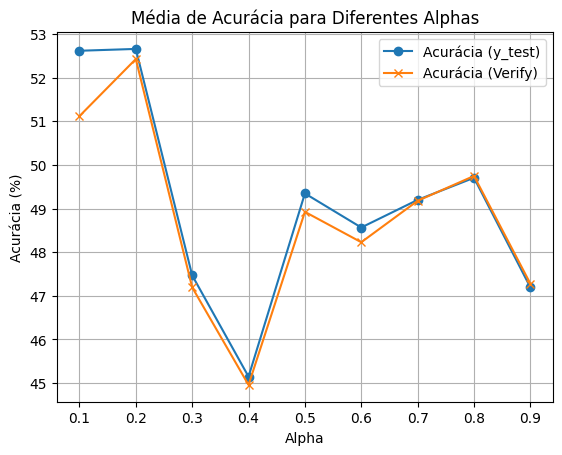

In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
import winsound


# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Criar uma lista para armazenar as médias das acurácias por alpha
mean_accuracy_by_alpha = []

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Listas para armazenar as acurácias por fold para esse alpha
    accuracy_scores_ytest_fold = []
    accuracy_scores_verify_fold = []

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar as acurácias por fold
        accuracy_scores_ytest_fold.append(accuracy_ytest)
        accuracy_scores_verify_fold.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    # Calcular a média de acurácia por alpha
    mean_accuracy_ytest = np.mean(accuracy_scores_ytest_fold)
    mean_accuracy_verify = np.mean(accuracy_scores_verify_fold)
    mean_accuracy_by_alpha.append((alpha, mean_accuracy_ytest, mean_accuracy_verify))

    print(f'Média de acurácia (y_test) para alpha {alpha}: {mean_accuracy_ytest:.2f}%')
    print(f'Média de acurácia (Verify) para alpha {alpha}: {mean_accuracy_verify:.2f}%')
    print('---')

# Exibir o resumo geral das médias
print("Resumo geral das médias:")
for alpha, acc_ytest, acc_verify in mean_accuracy_by_alpha:
    print(f'Alpha: {alpha:.2f} - Média Acurácia (y_test): {acc_ytest:.2f}% - Média Acurácia (Verify): {acc_verify:.2f}%')

# Opcional: Plotando as médias por alpha
import matplotlib.pyplot as plt

alphas, acc_ytest_values, acc_verify_values = zip(*mean_accuracy_by_alpha)

plt.plot(alphas, acc_ytest_values, label='Acurácia (y_test)', marker='o')
plt.plot(alphas, acc_verify_values, label='Acurácia (Verify)', marker='x')
plt.title("Média de Acurácia para Diferentes Alphas")
plt.xlabel('Alpha')
plt.ylabel('Acurácia (%)')
plt.legend()
plt.grid(True)
plt.show()
winsound.Beep(440, 300)

#### Time Series com verify

In [12]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Criar listas para armazenar os resultados gerais
all_predictions = []
all_verify_values = []
all_actual_values = []
all_accuracy_scores_ytest = []
all_accuracy_scores_verify = []

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X), o target (y) e a verificação (verify) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']
    verify = price_data['Verify']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y, verify], axis=1).dropna()
    X = data.iloc[:, :-2]
    y = data.iloc[:, -2]
    verify = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        y_verify = verify.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0, oob_score=True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Armazenar as predições e valores reais para análise posterior
        all_predictions.extend(y_pred)
        all_verify_values.extend(y_verify.values)
        all_actual_values.extend(y_test.values)

        # Calcular acurácia para y_test e verify
        accuracy_ytest = accuracy_score(y_test, y_pred) * 100.0
        accuracy_verify = accuracy_score(y_verify, y_pred) * 100.0

        # Armazenar os resultados das acurácias
        all_accuracy_scores_ytest.append(accuracy_ytest)
        all_accuracy_scores_verify.append(accuracy_verify)

        # Exibir resultados por fold
        print(f'Fold {fold}:')
        print(f' - Correct Prediction (y_test): {accuracy_ytest:.2f}%')
        print(f' - Correct Prediction (Verify): {accuracy_verify:.2f}%')
        fold += 1

    print('---')

# Resultados gerais
print("Resumo geral:")
print(f'Média de acurácia (y_test): {np.mean(all_accuracy_scores_ytest):.2f}%')
print(f'Média de acurácia (Verify): {np.mean(all_accuracy_scores_verify):.2f}%')


Alpha: 0.1
Fold 1:
 - Correct Prediction (y_test): 60.90%
 - Correct Prediction (Verify): 49.16%
Fold 2:
 - Correct Prediction (y_test): 67.82%
 - Correct Prediction (Verify): 48.74%
Fold 3:
 - Correct Prediction (y_test): 61.64%
 - Correct Prediction (Verify): 40.67%
Fold 4:
 - Correct Prediction (y_test): 64.05%
 - Correct Prediction (Verify): 57.44%
Fold 5:
 - Correct Prediction (y_test): 70.65%
 - Correct Prediction (Verify): 51.57%
---
Alpha: 0.2
Fold 1:
 - Correct Prediction (y_test): 53.25%
 - Correct Prediction (Verify): 50.21%
Fold 2:
 - Correct Prediction (y_test): 59.22%
 - Correct Prediction (Verify): 55.24%
Fold 3:
 - Correct Prediction (y_test): 58.07%
 - Correct Prediction (Verify): 45.70%
Fold 4:
 - Correct Prediction (y_test): 58.60%
 - Correct Prediction (Verify): 55.45%
Fold 5:
 - Correct Prediction (y_test): 55.45%
 - Correct Prediction (Verify): 48.32%
---
Alpha: 0.3
Fold 1:
 - Correct Prediction (y_test): 49.37%
 - Correct Prediction (Verify): 48.22%
Fold 2:
 - Co

#### Time Series sem Verify

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

# Definir o número de divisões para a validação cruzada
n_splits = 5

# Loop para cada alpha e realização de validação cruzada em série temporal
for alpha in alpha_list:
    # Definir as features (X) e o target (Y) dinamicamente
    X = price_data[['RSI',
                    f'k_percent_{alpha:.2f}',
                    f'r_percent_{alpha:.2f}',
                    f'Price_Rate_Of_Change_{alpha:.2f}',
                    f'MACD_{alpha:.2f}',
                    f'MACD_EMA_{alpha:.2f}',
                    f'OBV_{alpha:.2f}']]
    y = price_data[f'Prediction_{alpha:.2f}']

    # Remover possíveis valores NaN nas colunas selecionadas
    data = pd.concat([X, y], axis=1).dropna()
    X = data.iloc[:, :-1]
    y = data.iloc[:, -1]

    # Configurar o TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)

    print(f'Alpha: {alpha}')
    fold = 1
    for train_index, test_index in tscv.split(X):
        # Dividir os dados em treino e teste com base nos índices
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Criar o modelo de Random Forest
        rand_frst_clf = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=0,oob_score = True)

        # Ajustar o modelo aos dados de treino
        rand_frst_clf.fit(X_train, y_train)

        # Fazer previsões nos dados de teste
        y_pred = rand_frst_clf.predict(X_test)

        # Calcular e imprimir a acurácia para cada divisão
        accuracy = accuracy_score(y_test, y_pred) * 100.0
        print(f'Fold {fold}: Correct Prediction (%): {accuracy:.2f}')
        fold += 1

    print('---')


#### Salvando

In [ ]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

In [ ]:
price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/test_day.xlsx', index=False)